# MIDI-Trained Chord Recognition Model

## Data Preprocessing 
## 1. Load and Extract from midi_folder

In [50]:
import os
import json
import pretty_midi
import pandas as pd
import numpy as np
from collections import defaultdict
import mido
import io

# define chord type templates: intervals relative to root
CHORD_TEMPLATES = {
    "Major":         {0, 4, 7},
    "Minor":         {0, 3, 7},
    "Dominant 7th":  {0, 4, 7, 10},
    "Diminished":    {0, 3, 6},
    "Augmented":     {0, 4, 8},
}

PITCH_CLASS_NAMES = ['C', 'C#', 'D', 'D#', 'E', 'F',
                     'F#', 'G', 'G#', 'A', 'A#', 'B']

# normalize chord, removing octave transpositions 
def normalize_chord(chord_tuple):
    normalized_chord = {note % 12 for note in chord_tuple}  # keep only unique notes modulo 12
    return tuple(sorted(normalized_chord))

# identify and name chords 
def identify_named_chord(chord_tuple):
    if not chord_tuple:
        return "Unknown"

    pitch_classes = sorted({p % 12 for p in chord_tuple})
    for root in pitch_classes:
        transposed = sorted({(p - root) % 12 for p in pitch_classes})
        for label, template in CHORD_TEMPLATES.items():
            if set(transposed) == template:
                root_name = PITCH_CLASS_NAMES[root]
                return f"{root_name} {label}"
    return "Unknown"

# fixed mapping for chord vocab: all 12 roots * templates
def create_fixed_chord_vocab():
    ALL_CHORDS = [
        f"{pitch} {chord_type}"
        for pitch in PITCH_CLASS_NAMES
        for chord_type in CHORD_TEMPLATES.keys()
    ]
    chord_to_index = {chord: idx for idx, chord in enumerate(ALL_CHORDS)}
    return chord_to_index

# extract chord sequence
def midi_to_chord_sequence(midi_file, merge_threshold=0.3):
    #midi_data = pretty_midi.PrettyMIDI(midi_file)
    
    raw = mido.MidiFile(midi_file, clip=True)
    merged = mido.MidiFile() 
    merged.ticks_per_beat = raw.ticks_per_beat
    merged_track = mido.merge_tracks(raw.tracks)
    merged.tracks.append(merged_track)
    
    # dump to memory buffer
    buf = io.BytesIO()
    merged.save(file=buf)
    buf.seek(0)

    midi_data = pretty_midi.PrettyMIDI(buf)

    events = []
    # for each note, add two events: on/off
    for instrument in midi_data.instruments:
        if instrument.is_drum:
            continue
        for note in instrument.notes:
            events.append((note.start, 'on', note.pitch))
            events.append((note.end, 'off', note.pitch))
    
    # ？? if need to sort(events.sort(key=lambda x: x[0]))
    events.sort(key=lambda x: x[0])

    active_notes = set()  # track notes that are in use
    chords = []  # final list
    previous_chord = None
    chord_start_time = None
    last_event_time = 0

    # if note is starting, add to active set
    # if note ending, remove it from active set
    for time, action, pitch in events:
        if action == 'on':
            active_notes.add(pitch)
        elif action == 'off':
            active_notes.discard(pitch)

        current_chord = normalize_chord(active_notes) if active_notes else None
        chord_label = identify_named_chord(current_chord) if current_chord else None

        # if chord changed
        if chord_label != previous_chord:
            if previous_chord is not None and chord_start_time is not None:
                if time - chord_start_time >= merge_threshold:
                    chords.append((round(chord_start_time, 3), round(time, 3), previous_chord))
            chord_start_time = time
            previous_chord = chord_label

        last_event_time = time

    # capture final chord if any
    if previous_chord is not None and chord_start_time is not None:
        chords.append((round(chord_start_time, 3), round(midi_data.get_end_time(), 3), previous_chord))

    return chords, midi_data

# timeframe-level feature extraction and align with chord labels
def extract_frame_level_data(chords, midi_data, chord_to_index, frame_hop=1):
    end_time = midi_data.get_end_time()
    frame_times = np.arange(0, end_time, frame_hop)

    chroma = midi_data.get_chroma(fs=int(1 / frame_hop))
    chroma = chroma.T  # transpose to shape (frames, 12)

    data = []

    for i, t in enumerate(frame_times):
        frame_feature = chroma[i] if i < len(chroma) else np.zeros(12)
        label = None
        for start, end, chord in chords:
            if start <= t < end:
                if chord in chord_to_index:
                    label = chord_to_index[chord]
                break
        if label is not None:
            data.append((t, frame_feature, label))
    return data


# process all midi files in the folder, save to CSV
def process_midi_folder(input_folder, chord_csv, frame_csv, frame_hop=1):
    chord_rows = []
    frame_rows = []
    chord_to_index = create_fixed_chord_vocab()

    for root, _, files in os.walk(input_folder):
        for fname in files:
            if not fname.lower().endswith(('.mid','.midi')): continue
            path = os.path.join(root, fname)
            rel = os.path.relpath(path, input_folder)
            try:
                chords, midi = midi_to_chord_sequence(path)
                # chord-level
                for st, ed, ch in chords:
                    chord_rows.append([rel, st, ed, ch])
                # frame-level
                frames = extract_frame_level_data(chords, midi, chord_to_index, frame_hop)
                for t, feat, lbl in frames:
                    frame_rows.append([rel, t, *feat, lbl])

            except Exception as e:
                print(f"[ERROR] {rel}: {e}")

    # save to csv
    chord_df = pd.DataFrame(chord_rows, columns=["filename","start_time","end_time","chord"])
    chord_df.to_csv(chord_csv, index=False)
    cols = [f"chroma_{i}" for i in range(12)]
    frame_df = pd.DataFrame(frame_rows, columns=["filename","time", *cols, "label"])
    frame_df.to_csv(frame_csv, index=False)

    print(f"✔ Saved chords to: {chord_csv}")
    print(f"✔ Saved frames to: {frame_csv}")
    return chord_to_index


# def process_midi_folder(midi_folder, chord_output_csv, frame_output_csv, frame_hop=1):
#     chord_data = []
#     frame_data = []

#     chord_to_index = create_fixed_chord_vocab()

#     for midi_file in os.listdir(midi_folder):
#         if midi_file.endswith(".mid") or midi_file.endswith(".midi"):
#             file_path = os.path.join(midi_folder, midi_file)
#             try:
#                 chords, midi_data = midi_to_chord_sequence(file_path)
#                 for timestamp_start, timestamp_end, chord in chords:
#                     chord_data.append([midi_file, timestamp_start, timestamp_end, chord])
#             except Exception as e:
#                 print(f"Error processing {midi_file}: {e}")

#     # second pass to align frame-wise data using finalized vocab
#     for midi_file in os.listdir(midi_folder):
#         if midi_file.endswith(".mid") or midi_file.endswith(".midi"):
#             file_path = os.path.join(midi_folder, midi_file)
#             try:
#                 chords, midi_data = midi_to_chord_sequence(file_path)
#                 frame_entries = extract_frame_level_data(chords, midi_data, chord_to_index, frame_hop)
#                 for t, feat, label in frame_entries:
#                     frame_data.append([midi_file, round(t, 3)] + list(feat) + [label])
#             except Exception as e:
#                 print(f"Error processing {midi_file} for frame-level: {e}")

#     # save chord segment CSV
#     chord_df = pd.DataFrame(chord_data, columns=["filename", "start_time", "end_time", "chord"])
#     chord_df.to_csv(chord_output_csv, index=False)

#     # save frame-level CSV
#     feat_cols = [f"chroma_{i}" for i in range(12)]
#     frame_df = pd.DataFrame(frame_data, columns=["filename", "time"] + feat_cols + ["label"])
#     frame_df.to_csv(frame_output_csv, index=False)

#     print(f"Chord segments saved to {chord_output_csv}")
#     print(f"Frame-level data saved to {frame_output_csv}")
    
#     return chord_to_index

## 2. Extract and Combine to csv file

In [51]:
# paths
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

folder_to_process = 'midi_folder' # test use; change to 'lakh-midi-clean' for actual experiments

base = os.path.basename(folder_to_process.rstrip(os.sep))
chord_csv = os.path.join(output_dir, f"chord_dataset.csv")
frame_csv = os.path.join(output_dir, f"timeframe_dataset.csv")
vocab_json = os.path.join(output_dir, f"chord_vocab.json")

chord_to_index = process_midi_folder(folder_to_process, chord_csv, frame_csv)

with open(vocab_json, 'w') as f:
    json.dump(chord_to_index, f, indent=2)


# midi_folder = "midi_folder"  
# chord_output_csv = "chord_dataset.csv"
# frame_output_csv = "timeframe_dataset.csv"

# chord_to_index = process_midi_folder(midi_folder, chord_output_csv, frame_output_csv)

# with open("chord_vocab.json", "w") as f:
#     json.dump(chord_to_index, f)

✔ Saved chords to: output/chord_dataset.csv
✔ Saved frames to: output/timeframe_dataset.csv


## 3. One-hot Encoding

In [44]:
# one-hot encoding 
import pandas as pd
import numpy as np
import os
import json

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

frame_csv_path = "output/timeframe_dataset.csv"
chord_vocab_path = "output/chord_vocab.json"
output_onehot_csv_path = os.path.join(output_dir, "timeframe_onehot.csv")


# load from JSON file
with open(chord_vocab_path, "r") as f:
    chord_to_index = json.load(f)

# reverse
chord_to_index = {str(k): v for k, v in chord_to_index.items()}


def one_hot_encode_labels(label_indices, num_classes):
    return np.eye(num_classes)[label_indices]

# load original timeframe-level dataset
df = pd.read_csv(frame_csv_path)

# get label col
label_indices = df["label"].astype(int).values

# one-hot encoding 
num_classes = len(chord_to_index)
one_hot = one_hot_encode_labels(label_indices, num_classes)

# create DataFrame 
one_hot_columns = [f"class_{i}" for i in range(num_classes)]
one_hot_df = pd.DataFrame(one_hot, columns=one_hot_columns)

# combine with filename + time 
minimal_df = df[["filename", "time"]].reset_index(drop=True)
result_df = pd.concat([minimal_df, one_hot_df], axis=1)

result_df.to_csv(output_onehot_csv_path, index=False)

print(f"One-hot encoded data saved to {output_onehot_csv_path}")

One-hot encoded data saved to output/timeframe_onehot.csv


## Baseline Model: SVM

In [45]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

frame_csv_path = "output/timeframe_dataset.csv"
df = pd.read_csv(frame_csv_path)

# split to train and test dataset
feature_cols = [f"chroma_{i}" for i in range(12)]
X = df[feature_cols].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# RBF kernel 
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train)

y_pred = svm_model.predict(X_test_scaled)

# print confusion metrics with zero_division fix
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.71      0.57       185
           1       0.50      0.38      0.43        24
           2       0.47      0.37      0.41        19
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2
           5       0.55      0.68      0.61        31
           6       0.75      0.46      0.57        13
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         2
          10       0.59      0.74      0.66       133
          11       0.53      0.47      0.49        45
          12       0.57      0.29      0.38        14
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.69      0.74      0.71        65
          16       0.00      0.00      0.00         5
    

## 1. CNN Model

In [20]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# === 1. LOAD DATA ===
df = pd.read_csv("output/timeframe_dataset.csv")

# Chroma features
feature_cols = [f"chroma_{i}" for i in range(12)]
X = df[feature_cols].values.astype(np.float32)
y = df["label"].values.astype(int)

# === 2. REMAP LABELS ===
le = LabelEncoder()
y_dense = le.fit_transform(y)
num_classes = len(le.classes_)

# Optional: save mapping for interpretability
index_to_label = dict(enumerate(le.classes_))

# === 3. TRAIN/TEST SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y_dense, test_size=0.2, random_state=42, stratify=y_dense
)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train).unsqueeze(1)  # (B, 1, 12)
X_test_tensor = torch.tensor(X_test).unsqueeze(1)
y_train_tensor = torch.tensor(y_train)
y_test_tensor = torch.tensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [4]:
# cnn model architecture
class ChromaCNN(nn.Module):
    def __init__(self, num_classes):
        super(ChromaCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(32 * 6, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # (B, 16, 12)
        x = self.pool(x)            # (B, 16, 6)
        x = F.relu(self.conv2(x))   # (B, 32, 6)
        x = x.view(x.size(0), -1)   # flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [5]:
# training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChromaCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch 1, Loss: 297.8409
Epoch 2, Loss: 225.2875
Epoch 3, Loss: 196.8446
Epoch 4, Loss: 184.0336
Epoch 5, Loss: 176.8714
Epoch 6, Loss: 171.5461
Epoch 7, Loss: 167.2862
Epoch 8, Loss: 164.7154
Epoch 9, Loss: 161.6453
Epoch 10, Loss: 159.4607
Epoch 11, Loss: 157.4819
Epoch 12, Loss: 154.8853
Epoch 13, Loss: 153.1711
Epoch 14, Loss: 152.5662
Epoch 15, Loss: 149.6895
Epoch 16, Loss: 148.5393
Epoch 17, Loss: 147.0645
Epoch 18, Loss: 146.0917
Epoch 19, Loss: 144.8855
Epoch 20, Loss: 143.8104


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.72      0.59       185
           1       0.62      0.42      0.50        24
           2       0.45      0.47      0.46        19
           3       0.00      0.00      0.00         1
           4       1.00      0.50      0.67         2
           5       0.61      0.65      0.62        31
           6       0.55      0.46      0.50        13
           7       0.67      0.50      0.57         4
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         2
          10       0.64      0.71      0.67       133
          11       0.53      0.53      0.53        45
          12       0.83      0.36      0.50        14
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.75      0.75      0.75        65
          16       0.60      0.60      0.60         5
    

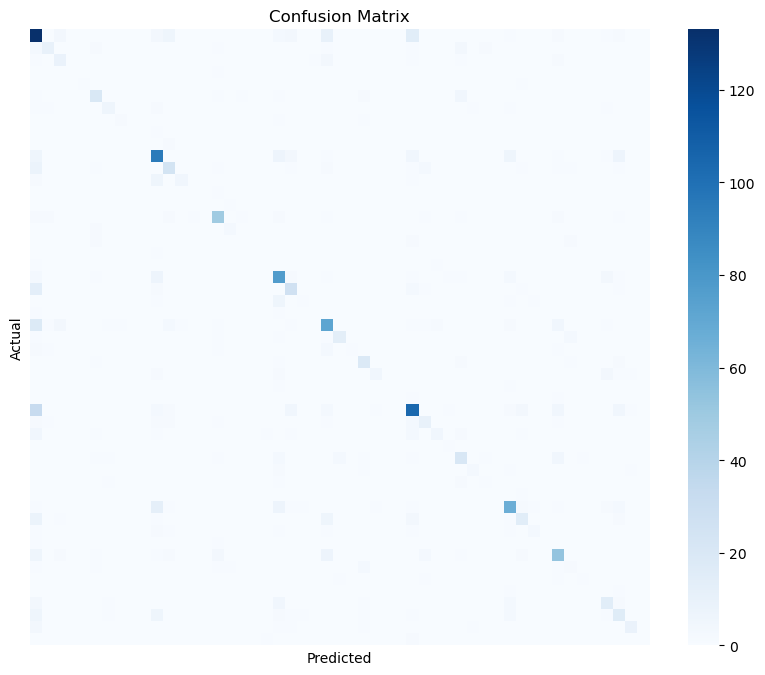

In [15]:
# evaluation 
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, zero_division=0))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues", square=False, cbar=True, xticklabels=False, yticklabels=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Hybrid Model (CNN+BiLSTM)

In [16]:
# data loader
# function to modify the input as small winddow of 16 frames
def create_sequences(X, y, window_size):
    sequences = []
    labels = []

    for i in range(len(X) - window_size):
        seq = X[i:i + window_size]
        label = y[i + window_size - 1]  # label for the last frame
        sequences.append(seq)
        labels.append(label)

    return np.array(sequences), np.array(labels)
  
window_size = 16
X_seq, y_seq = create_sequences(X, y_dense, window_size)

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [17]:
# CNN+BiLSTM model architecture
class CNN_BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(CNN_BiLSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.bilstm = nn.LSTM(input_size=32, hidden_size=hidden_dim,
                              num_layers=1, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 for bidirectional

    def forward(self, x):
        # x: (B, T, C) → we want conv over chroma channels per time
        x = x.permute(0, 2, 1)      # (B, C, T)
        x = self.relu(self.conv1(x))  # (B, 32, T)
        x = x.permute(0, 2, 1)        # (B, T, 32)
        output, _ = self.bilstm(x)    # (B, T, 2*hidden_dim)
        x = output[:, -1, :]          # take last frame's output
        return self.fc(x)             # (B, num_classes)

In [18]:
# model training 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_BiLSTM(input_dim=12, hidden_dim=64, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 265.0159
Epoch 2, Loss: 179.9075
Epoch 3, Loss: 156.1780
Epoch 4, Loss: 143.0000
Epoch 5, Loss: 134.3216
Epoch 6, Loss: 127.5430
Epoch 7, Loss: 122.4699
Epoch 8, Loss: 116.7095
Epoch 9, Loss: 111.5661
Epoch 10, Loss: 108.1697
Epoch 11, Loss: 104.0492
Epoch 12, Loss: 99.9601
Epoch 13, Loss: 96.8489
Epoch 14, Loss: 93.2006
Epoch 15, Loss: 91.2193
Epoch 16, Loss: 87.6795
Epoch 17, Loss: 84.1563
Epoch 18, Loss: 82.3646
Epoch 19, Loss: 80.2934
Epoch 20, Loss: 77.9676


In [19]:
# evaluation 
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, zero_division=0))

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.77      0.69       185
           1       0.52      0.46      0.49        24
           2       0.64      0.37      0.47        19
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2
           5       0.62      0.65      0.63        31
           6       0.43      0.23      0.30        13
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         2
          10       0.72      0.77      0.74       133
          11       0.62      0.66      0.64        44
          12       0.38      0.21      0.27        14
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.63      0.72      0.67        65
          16       0.00      0.00      0.00         5
    